In [28]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [13]:
# I have loaded the Titanic dataset from a CSV file.
data = pd.read_csv('/content/train.csv')

In [14]:
# I have handled missing values in the dataset to ensure all features are complete.
imputer = SimpleImputer(strategy='mean')
data['Age'] = imputer.fit_transform(data[['Age']])
data['Fare'] = imputer.fit_transform(data[['Fare']])
data['Embarked'].fillna('S', inplace=True)

<ipython-input-14-5dcfb378549e>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Embarked'].fillna('S', inplace=True)


In [15]:
# I have encoded the categorical variables ('Sex' and 'Embarked') into numeric values using LabelEncoder.
label_encoders = {}
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

In [16]:
# I have prepared the features (X) and target (y) for model training.
X = data.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = data['Survived']

In [17]:
# I have split the dataset into training and validation sets to evaluate the model's performance.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# I have converted the datasets into DMatrix format, which is optimized for XGBoost computations.
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [23]:
# I have defined a custom objective function for binary classification.
# The function calculates the gradient and hessian of the logistic loss.
def custom_logistic_objective(preds, dtrain):
    # I have extracted the true labels (y_true) from the DMatrix.
    y_true = dtrain.get_label()  # Labels are stored in the DMatrix

    # I have calculated the predicted probabilities using the sigmoid function.
    # This ensures that the predictions are bounded between 0 and 1.
    preds = 1 / (1 + np.exp(-preds))  # Sigmoid transformation

    # I have calculated the gradient of the logistic loss.
    # The gradient represents the direction and magnitude of change needed to minimize the loss.
    grad = preds - y_true  # Gradient: difference between predicted and actual values

    # I have calculated the hessian of the logistic loss.
    # The hessian represents the curvature of the loss function, which helps in optimizing the learning process.
    hess = preds * (1 - preds)  # Hessian: second derivative of the loss

    return grad, hess

In [24]:
# I have trained an XGBoost model using the custom objective function.
# By specifying the `obj` parameter, I have replaced the default objective with my custom implementation.
params = {
    'max_depth': 6,
    'eta': 0.1
}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dval, 'validation')],
    obj=custom_logistic_objective,  # Use the custom objective function
    early_stopping_rounds=10
)


[0]	validation-rmse:0.40939
[1]	validation-rmse:0.37933
[2]	validation-rmse:0.39681
[3]	validation-rmse:0.45524
[4]	validation-rmse:0.52059
[5]	validation-rmse:0.59699
[6]	validation-rmse:0.67455
[7]	validation-rmse:0.74947
[8]	validation-rmse:0.82287
[9]	validation-rmse:0.89479
[10]	validation-rmse:0.96497
[11]	validation-rmse:1.03398


In [25]:
# I have made predictions on the validation set using the trained XGBoost model.
# Since the custom objective outputs raw scores, I applied the sigmoid function to convert them into probabilities.
y_pred_prob = 1 / (1 + np.exp(-bst.predict(dval)))  # Apply sigmoid to get probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

In [26]:
# I have evaluated the model's performance using accuracy.
print("Accuracy:", accuracy_score(y_val, y_pred))


Accuracy: 0.8044692737430168


<Figure size 1000x600 with 0 Axes>

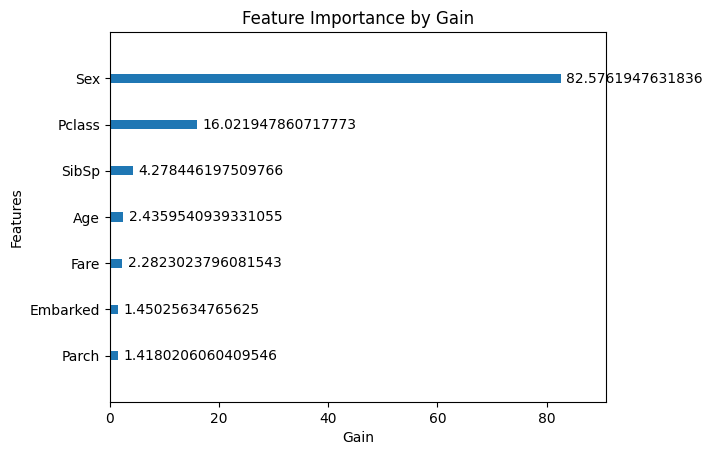

In [29]:
# I have visualized the feature importance to understand which features contribute most to the model's predictions.
plt.figure(figsize=(10, 6))
xgb.plot_importance(bst, importance_type='gain', grid=False)
plt.title("Feature Importance by Gain")
plt.xlabel("Gain")
plt.ylabel("Features")
plt.show()